### Esse notebook tem o objetivo de apresentar com teoria e aplicação uma técnica de tuning de hiperparâmetros e uma técnica de validação cruzada, respectivamente Grid Search e K-fold.
### Para essa demonstração será usado o dataset do desafio "Titanic - Machine Learning from Disaster" da plataforma Kaggle por se tratar de um problema com complexidade suficiente para que seja possível observar os impactos de cada técnica nos resultados obtidos.
### Dataset disponível em https://www.kaggle.com/c/titanic/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_inic = pd.read_csv('dados_titanic/train.csv',index_col='PassengerId')
df_inic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_inic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Para este objetivo iremos utilizar apenas as features: "Survived","Sex","Age", "SibSp" e "Parch". Observando as informações acima é possível notar que "Age" possui valores faltantes. Esse problema deve ser tratado, pois há modelos de ML que não funcionam quando há campos inválidos nos dados.

Nota-se também que SibSp e Parch são referentes à familiares abordo, Sendo a primeira referente a irmãos ou cônjuge e a segunda referente a pais ou filhos. Essas variáveis serão utilizadas para a criação de outras duas, "Small_family" e "Alone". Respectivamente inidcam se o passageiro possui de três a um membro da família abordo. A segunda indica se o apssageiro não possui membros da família abordo.

In [4]:
def fill_age(df):
    '''Obtém as idades médias por cada título dos passageiros e preenche os valores faltantes
       utilizando este mesmo discriminador'''
    
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

    title_mean_age = df.groupby(df["Title"])["Age"].mean()
    for title in df["Title"]:
        df['Age'] = (np.where((df.Age.isnull()) & (df.Title== title),
                          title_mean_age.loc[f"{title}"], df["Age"]))     
    if df["Age"].isnull().sum() == 0:
        print("Done! No more missing values in Age")

def remove_features(df,drop_list):
    '''Remove features do dataset de acordo com a drop_list.'''
    
    for feature in drop_list:
        df.drop(feature,axis=1,inplace=True)
        
def create_family(df):
    '''Cria as features 'Family_Size', 'Small_Family' e 'Alone'.'''
    
    df["Family_Size"] = df["SibSp"] + df["Parch"]
    df["Small_Family"] = np.where(df["Family_Size"] <= 3,1,0)
    df["Alone"] = np.where(df["Family_Size"] == 0,1,0)


In [5]:
# Tratando valores faltantes em Age
fill_age(df=df_inic)

Done! No more missing values in Age


In [6]:
# Criando features small_family e Alone
create_family(df=df_inic)
df_inic.drop("Family_Size",axis=1,inplace=True)

In [7]:
# Removendo features não utilizadas
drop_list = ['Pclass','Name','Ticket','Fare','Cabin','Embarked','Title','SibSp','Parch']

remove_features(df=df_inic,drop_list=drop_list)

In [8]:
# Transformando as categóricas em dummies
df_inic = pd.get_dummies(data=df_inic,prefix='d',columns=['Sex'])
# Removendo a dummie "d_male" que é complementar à d_female. Estamos removendo uma feature redundante
df_inic.drop("d_male",axis=1,inplace=True)

In [9]:
# Normalizando a feature Age
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy=False)
scaler.fit_transform(df_inic['Age'].values.reshape(-1,1));

In [10]:
# Observando o dataframe que será utilizado nos modelos de ML
df_inic.head()

,Survived,Age,Small_Family,Alone,d_female
PassengerId,,,,,
1,0,-0.584387,1,0,0
2,1,0.621365,1,0,1
3,1,-0.282949,1,1,1
4,1,0.395286,1,0,1
5,0,0.395286,1,1,0


## Aplicando em modelos de ML

In [11]:
X = df_inic.drop('Survived',axis=1)
y = df_inic['Survived']

In [12]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost

from sklearn.metrics import accuracy_score

SEED = 144
np.random.seed(SEED)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(668, 4) (223, 4) (668,) (223,)


In [14]:
svc_model = SVC()
svc_model.fit(X_train,y_train)
svc_y_pred = svc_model.predict(X_test)
svc_score = round(svc_model.score(X_train,y_train)*100,2)
print("Train score:",svc_score)
print("accuracy_score:", round(accuracy_score(svc_y_pred,y_test)*100,2))

Train score: 82.49
accuracy_score: 83.86


In [15]:
gradient_boosting_model = GradientBoostingClassifier()
gradient_boosting_model.fit(X_train,y_train)
gradient_y_pred = gradient_boosting_model.predict(X_test)
gradient_boosting_score = round(gradient_boosting_model.score(X_train,y_train)*100,3)
print("Train score:",gradient_boosting_score)
print("accuracy_score:", round(accuracy_score(gradient_y_pred,y_test)*100,2))

Train score: 84.281
accuracy_score: 83.41


## O que é e para que serve a validação cruzada?

Consta na documentação da biblioteca scikit-learn (https://scikit-learn.org/stable/modules/cross_validation.html) que a validação cruzada fornece informações sobre o quanto um modelo é capaz de generalizar suas previsões, ou seja, se adequar a novos dados inseridos no teste e consequentemente na etapa de produção (deploy), evitando assim problemas como overfitting.

Na prática, a técnica conhecida como k-fold consiste em separar os dados em k partes (k folds), treinar o modelo com as k-1 partes e validá-lo com a parte não utilizada no treinamento. Esse processo se repete até que cada parte tenha sido utilizada como validação, ou seja, após k iterações. O número de partes é arbitrário, mas seu valor padrão é 10. Dessa forma o modelo é treinado com nove partes e depois validado com uma e o processo total requer 10 iterações.

### Viés e Variância na vizualização da curva de aprendizado para um modelo SVC
Na vizualização abaixo são utilizados diferentes tamanhos para os dados de treino, estes vão aumentando no decorrer das iterações. O resultado obtido, portanto será uma indicação da influência da quantidade de dados na performance deste modelo, vamos analizar os resultados sob o ponto de vista de viés e variância.

In [16]:
X = pd.concat([X_train,X_test])
y = pd.concat([y_train,y_test])

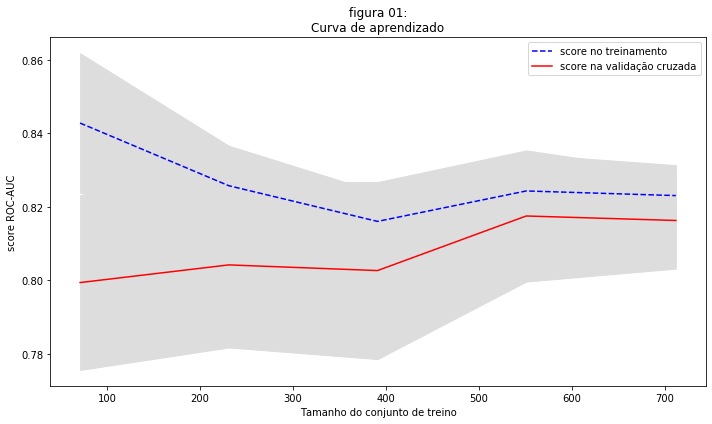

In [17]:
train_sizes,train_scores,test_scores=model_selection.learning_curve(estimator = SVC(),
                                                          X=X,y=y,scoring='roc_auc',
                                                          random_state=SEED
                                                         )

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(10,6))
plt.plot(train_sizes, train_mean, '--', color="blue",  label="score no treinamento")
plt.plot(train_sizes, test_mean, color="red", label="score na validação cruzada")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("figura 01:\nCurva de aprendizado")
plt.xlabel("Tamanho do conjunto de treino"), plt.ylabel("score ROC-AUC"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Obseve que à medida em que vão sendo adicionados mais dados no treinamento do modelo o score da validação cruzada se aproxima do score do treinamento, o viés do treinamento aumenta e o da validação cruzada diminui. Isso indica que o grau de generalização do modelo está aumentando, ou seja, nos distanciamos do underfitting e do overftting. Também é possível observar esse fato atentando para a variância (parte cinza do gráfico). Conforme acrescentamos dados ao treinamento do modelo, a variância diminui indicando melhor generalização. 

### Aplicando validação cruzada com k-fold a um grupo de modelos 

In [18]:
# Modelo SVM com ahiperparâmetros default.
model_svc = SVC(random_state=SEED)
model_svc.fit(X,y)
kfold = model_selection.KFold(n_splits=10)
s_svm = model_selection.cross_val_score(model_svc,X,y, scoring="roc_auc",cv=kfold)
print('model_svc AUC: '
      f'{s_svm.mean():0.3f} STD: {s_svm.std():0.2f}')

model_svc AUC: 0.810 STD: 0.02


In [19]:
# Modelo RandomForest com ahiperparâmetros default.
model_rf = RandomForestClassifier(random_state=SEED)
model_rf.fit(X,y)
kfold = model_selection.KFold(n_splits=10)
s_rf = model_selection.cross_val_score(model_rf,X,y, scoring="roc_auc",cv=kfold)
print('model_svc AUC: '
      f'{s_rf.mean():0.3f} STD: {s_rf.std():0.2f}')

model_svc AUC: 0.809 STD: 0.04


In [20]:
# Modelo XGBoost com ahiperparâmetros default.
model_xgb = xgboost.XGBClassifier(random_state=SEED)
model_xgb.fit(X,y)
kfold = model_selection.KFold(n_splits=10)
s_xgb = model_selection.cross_val_score(model_xgb,X,y, scoring="roc_auc",cv=kfold)
print('model_xgb AUC: '
      f'{s_xgb.mean():0.3f} STD: {s_xgb.std():0.2f}')

model_xgb AUC: 0.826 STD: 0.05


## O que é e para que serve o Grid Search?

Grid Search é um método que utiliza a busca exaustiva para encontrar as melhores combinações de hiperparâmetros em um dado modelo já instanciado. A busca exaustiva mencionada acima nada mais é do que realizar fit, predict e cálcular o score de um modelo para cada combinação possível dos hiperparâmetros previamente escolhidos.

Pela biblioteca scikit-learn, após a aplicação do método GridSearchCV(), O comando sorted(clf.cv_results_.keys()) retorna a lista de métodos para obtenção dos dados calculados pelo Grid Search. Na demonstração abaixo são utilizados ".best_score_" e ".best_params_" que irão retornar respectivamente o melhor score dentre as combinações e a melhor combinação de hiperparâmetros.

## Buscando melhores combinações de hiperparâmetros com Grid Search.

In [21]:
# Definindo uma função para modularizar a aplicação do Grid Search
def grid_s(X,y,model,params,scoring_metric="roc_auc"):
    '''Aplica Grid Search em um modelo já instanciado. 
        - model: Modelo já instanciado (sem default)
        - params: dicionário com os hiperpárâmetros para testes (sem default)
        - scoring_metric: métrica de validação (default = 'roc_auc')
       Obs: requer importação de model_selection da scikit-learn'''
    
    grid = model_selection.GridSearchCV(estimator=model,
                                        param_grid=params,
                                        scoring=scoring_metric)
    grid.fit(X,y)
       
    return (grid.best_score_,grid.best_params_)

In [22]:
# Modelo SVM
model_svc = SVC()
# Lista de hiperparâmetros para teste
params_svc = {'kernel': ('linear','sigmoid','rbf'),
              'C' : [0.1, 1, 10, 13, 15, 20,],
              'gamma' : [0.1, 1, 2, 3, 4, 5, 'scale',],
              'random_state' : [SEED],
             }

model_svc_score, model_svc_params = grid_s(X=X,y=y,model=model_svc,
                                          params=params_svc,
                                          scoring_metric='roc_auc')

print(f'Score da melhor combinação de hiperparâmetros: {model_svc_score}\n'
      f'Melhor combinação: {model_svc_params}')

Score da melhor combinação de hiperparâmetros: 0.8223696519620287
Melhor combinação: {'C': 20, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 144}


In [23]:
# Modelo RandomForest
model_rf = RandomForestClassifier()
# Lista de hiperparâmetros para teste
params_rf = {'n_estimators' : [50, 100, 150,],
             'max_depth' : [1, 5, 10, 15, 20,],
             'random_state' : [SEED]}

model_rf_score, model_rf_params = grid_s(X=X,y=y,model=model_rf,
                                          params=params_rf,
                                          scoring_metric='roc_auc')

print(f'Score da melhor combinação de hiperparâmetros: {model_rf_score}\n'
      f'Melhor combinação: {model_rf_params}')

Score da melhor combinação de hiperparâmetros: 0.833898655955837
Melhor combinação: {'max_depth': 5, 'n_estimators': 50, 'random_state': 144}


In [24]:
# Modelo XGBoost
model_xgb = xgboost.XGBClassifier()
# Lista de hiperparâmetros para teste
params_xgb = {'n_estimators' : [50, 100, 150,],
             'max_depth' : [1, 5, 10, 15, 20,],
             'learning_rate' : [0.01, 0.1, 0.2, 1],
             'random_state' : [SEED]}

model_xgb_score, model_xgb_params = grid_s(X=X,y=y,model=model_xgb,
                                          params=params_xgb,
                                          scoring_metric='roc_auc')

print(f'Score da melhor combinação de hiperparâmetros: {model_xgb_score}\n'
      f'Melhor combinação: {model_xgb_params}')

Score da melhor combinação de hiperparâmetros: 0.8332755983780175
Melhor combinação: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'random_state': 144}


## Aplicando validação cruzada com K-fold nos modelos já tunados

In [25]:
# Modelo SVM com a combinação de hiperparâmetros indicada pelo Grid Search.
model_svc = SVC(C=20,gamma='scale',kernel='rbf', random_state=SEED)
model_svc.fit(X,y)
kfold = model_selection.KFold(n_splits=10)
s_svm_gs = model_selection.cross_val_score(model_svc,X,y, scoring="roc_auc",cv=kfold)
print('model_svc AUC: '
      f'{s_svm_gs.mean():0.3f} STD: {s_svm_gs.std():0.2f}')

model_svc AUC: 0.824 STD: 0.02


In [26]:
# Modelo RandomForest com a combinação de hiperparâmetros indicada pelo Grid Search.
model_rf = RandomForestClassifier(max_depth = 5, n_estimators = 50, random_state=SEED)
model_rf.fit(X,y)
kfold = model_selection.KFold(n_splits=10)
s_rf_gs = model_selection.cross_val_score(model_rf,X,y, scoring="roc_auc",cv=kfold)
print('model_rf AUC: '
      f'{s_rf_gs.mean():0.3f} STD: {s_rf_gs.std():0.2f}')

model_rf AUC: 0.831 STD: 0.04


In [27]:
# Modelo XGBoost com a combinação de hiperparâmetros indicada pelo Grid Search.
model_xgb = xgboost.XGBClassifier(learning_rate=0.1,max_depth = 5, n_estimators = 100, random_state=SEED)
model_xgb.fit(X,y)
kfold = model_selection.KFold(n_splits=10)
s_xgb_gs = model_selection.cross_val_score(model_xgb,X,y, scoring="roc_auc",cv=kfold)
print('model_xgb AUC: '
      f'{s_xgb_gs.mean():0.3f} STD: {s_xgb_gs.std():0.2f}')

model_xgb AUC: 0.831 STD: 0.05


## Comparando os scores
Abaixo serao comparados os scores calculados pelo método ROC_AUC nos modelos com hiperpaâmetros default com os scores dos modelos com hiperpaâmetros indicados pelo método Grid Search. Para que não haja risco de overfitting, em ambos os casos foi utilizada a validação cruzada k-fold. Dessa forma pode haver uma comparação justa.

In [28]:
print('Modelos com hiperparâmetros default:\n'
      f'SVC: {s_svm.mean():0.3f}\nRandomForest: {s_rf.mean():0.3f}\nXGBoost: {s_xgb.mean():0.3f}\n\n'
      'Modelos com hiperparâmetros indicados pelo Grid Search:\n'
      f'SVC: {s_svm_gs.mean():0.3f}\nRandomForest: {s_rf_gs.mean():0.3f}\nXGBoost: {s_xgb_gs.mean():0.3f}'
     )

Modelos com hiperparâmetros default:
SVC: 0.810
RandomForest: 0.809
XGBoost: 0.826

Modelos com hiperparâmetros indicados pelo Grid Search:
SVC: 0.824
RandomForest: 0.831
XGBoost: 0.831


## Conclusão

A utilização do método de Grid Search foi capaz de aumentar os scores para os três modelos testados, no algoritmo XGBoost, porém, esse aumento não foi tão expressivo quanto nos demais. Além disso esse resultado se torna mais confiável pela utilização da validação cruzada que garante uma boa generalização desses modelos.

Com isso o objetivo deste notebook é cumprido. Como complemento podem ser utilizados testes estatísticos para calcular o ganho real da aplicação das técnicas mencionadas acima e até mesmo entender se o aumento do score do algoritmo XGBoost foi estatisticamente significante, pois o método Grid Search possui um custo computacional relativamente alto. Caso o ganho em score não seja significante utilizar esse método pode causar efeitos negativos na eficiência da aplicação.